# **6장 지도 학습 : 분류**

<p>

회귀 문제는 목표 데이터가 연속된 수치였지만, 분류 문제에서 목표 데이터는 '클래스'이다. 클래스는 예를 들어 정수로 순서를 할당할 수 있지만, 그 순서는 의미가 없는 카테고리를 말한다.

또한 이 장에서는 매우 중요한 확률의 개념을 도입한다. 지금까지의 모델은 목표 데이터의 예측 값을 출력하는 함수였지만
이제부터는 확률을 출력하는 함수를 고려한다. 확률의 개념을 도입함으로써 예측의 '불확실성'을 정량적으로 다룰 수 있다.



---

## **6.1** 1차원 입력 2클래스 분류
 먼저 가장 간단한 입력 정보가 1차원이고, 분류할 클래스가 두 가지인 경우를 고려한다.
### **6.1.1** 문제 설정

1차원의 입력 변수를 xn으로 나타내고 그 목표 변수를 tn으로 한다. n은 데이터의 인덱스이다.
tn은 0 또는 1만을 갖는 변수로, 클래스 0이면 0, 클래스 1이면 1을 갖는다. 분류 문제의 경우 이 tn을 클래스, 카테고리, 또는 라벨이라고 한다.
<p> 예를 들어 곤충 N 마리의 데이터를 가정한다. 각각의 무게를 xn으로, 각각의 성별을 tn으로 나타낸다.
tn은 0 또는 1로 0이면 암컷을 나타낸다. 이 데이터를 기초로 무게를 통해 성별을 예측하는 모델을 만드는 것이 목적이다.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(seed = 0) # fixing random number

X_min = 0
X_max = 2.5
X_n = 30
X_col = ['cornflowerblue', 'gray']
X = np.zeros(X_n) # input data
T = np.zeros(X_n, dtype = np.uint8) # 목표데이터
Dist_s = [0.4, 0.8] # start point of distribution
Dist_w = [0.8, 1.6] # width of distribution
Pi = 0.5 # proportion of class 0

for n in range(X_n):
    wk = np.random.rand()
    T[n] = 0 * (wk < Pi) + 1 * (wk >= Pi) # (A) 암컷이 될 확률을 0.5 로 무작위로 결정한다.
    X[n] = np.random.rand() * Dist_w[T[n]] + Dist_s[T[n]] # (B)

print('X = '+str(np.round(X,2)))
print('T = '+ str(T))

X = [1.94 1.67 0.92 1.11 1.41 1.65 2.28 0.47 1.07 2.19 2.08 1.02 0.91 1.16
 1.46 1.02 0.85 0.89 1.79 1.89 0.75 0.9  1.87 0.5  0.69 1.5  0.96 0.53
 1.21 0.6 ]
T = [1 1 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1 1 0 1 0]


30 개의 무게 데이터 X와 성별 T가 생성된다.

우선, 암수를 확률적으로 결정한다. 암컷이 될 확률은 Pi = 0.5으로 하여 무작위로 결정한다.
True = 1, False = 0으로 해석되므로 wk를 0~1의 난수로 정한 후, wk < Pi라면 T[n] = 0x1 + 1x0 = 0 이 되고 wk >= pi 이면 T[n] = 0x0 + 1x1 = 1이 되는 구조이다.

그 다음, 암컷이라면 Dist_s[0] = 0.4에서 폭 Dist_w[0] = 0.8의 균일(0.4~1.2)한 분포에서 질량을 샘플링하고 수컷이라면 Dist_s[1] = 0.8에서 폭 Dist_w[1] = 1.6의 균일한 분포에서 질량을 샘플링한다. *교제에서 수컷의 분포 인덱스가 잘못된 것으로 보임.

In [3]:
print(np.random.rand()) # 0~1 사이의 무작위 랜덤을 생성한다.

0.15896958364551972


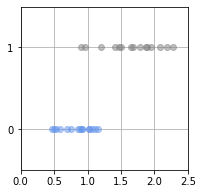

In [4]:
def show_data1(x, t):
    K = np.max(t) + 1
    for k in range(K):
        plt.plot(x[t == k], t[t == k], X_col[k], alpha=0.5, linestyle='none', marker='o') # (B)
        # 분포를 표시하는 코드. 이 코드는 k 루프 안에 있는데, 처음 k = 0의 처리는 t == 0일 때, x와 t만 추출하여 플롯하는 명령이다.
        # x[t==0]을 사용하면 t == 0을 채우는 요소 번호 x가 추출되므로 매우 편리하다.
        plt.grid(True)
        plt.ylim(-.5, 1.5)
        plt.xlim(X_min, X_max)
        plt.yticks([0, 1])
# main
fig = plt.figure(figsize = (3, 3))
show_data1(X, T)
plt.show()

In [5]:
print(np.max(T)+1)

2


문제를 푸는 방침은 수컷과 암컷을 분리하는 경계선을 결정하는 것이다. 이것을 결정 경계라고 한다. 결정 경계가 정해지면 새로운 질량 데이터가 결정 경계보다 작으면 암컷으로 예상하고 크면 수컷으로 예측할 수 있다.
예를 들어 x = 1.0인 수직선을 결정 경계로 설정할 수 있다.

그럼 어떻게 결정 경계를 결정하면 좋은 가? 우선 5장의 선형 회귀 모델을 사용하는 것이다. 클래스를 0과 1의 값으로 해석하여 데이터의 분포에 직선을 맞추는 것이다. 그리고 그 직선이 0.5의 값을 갖는 곳을 결정 경계로 한다. 결론부터 말하자면, 이 방법은 잘 통하지 않는 경우가 있다.

교재 그림 6-3에서 볼 수 있듯, 질량이 충분히 커서 확실하게 수컷으로 판정할 수 있는 데이터 점에서도 직선이 데이터 점에 겹쳐져 있지 않기 때문에 오차가 발생한다.
이 오차를 해소하려는 힘이 작용하기 때문에 결정 경계가 수컷 쪽에 끌려가는 것이다. 이 현상은 빗나간 값이 클수록 심각해진다.


<br>

<hr>

<br>

### 6.1.2 확률로 나타내는 클래스 분류

선형 모델을 분류 문제에 그대로 적용하는 것은 무리다.

인공데이터로 데이터를 생성하고 있기 때문에 실제 데이터의 분포를 알고 있다. 질량이 x < 0.8g이면 확실히 그 곤충은 암컷이다. 또한 1.2.g 이상이면 수컷이다. 질량 x가 0.8에서 1.2g 사이일 때만 둘 다 있으므로 100% 예측하는 것은 불가능하다.

그러나 질량 x가 0.8 ~ 1.2 사이일 경우 전혀 예측하지 못하는 것은 아니다. 결론부터 말하자면, 수컷일 확률은 1/3이다. 처럼 모호성을 확률로 포함한 예측은 가능하다.

교재 6-4 그림을 보면, 수컷의 분포를 나타낸 회색 영역에서 100마리의 수컷 데이터가 균일하게 분포하고 있다고 가정한다. 마찬가지로 암컷의 분포를 나타내는 파란색 영역에 100마리 암컷의 데이터가 균일하게 분포하고 있다고 가정한다. 그렇다면 질량 x가 0.8에서 1.2 사시에서는 암컷의 데이터 쪽이 수컷의 데이터보다 2 배 많이 집중된 것으로 나타난다. 겹처진 x의 범위에서 무작위로 데이터를 선택하면 수컷일 확률은 1/3이 되는 것을 알 수 있다.

수컷일 확률은 x에 따라 달라지는데, x < 0.8일 때라면 수컷이 아니기 때문에 확률은 0이 된다. 또한 1.2보다 높은 경우엔 수컷일 확률은 1이다.

이 같은 x에 대해 t = 1일 확률은 조건부 확률을 사용하여 나타낼 수 있다.

<br>

**P(t = 1 | x)**

<br>

이 조건부 확률은 x의 함수로 볼 수 있다. 모든 x에 대해 플롯하면 6-4 그림 아래 그래프 처럼 계단같은 그래프가 된다.

이 조건부 확률의 계단형 그래프는 클래스 분류의 답을 나타낸다고 할 수 있다. 어떤 클래스로 분류할지 명확하게 예측할 수 없는 불확실한 영억도 확률적인 예측으로 나타난다. 이 방법은 불확실성을 명확히 표현할 수 있다는 점에서 직선에 의한 피팅보다 우수하다.

하지만 이 경우엔 결정 경계를 어디에 그려야 하는게? 결정 경계의 오른쪽을 수컷으로, 왼쪽을 암컷으로 예측할 때 확률이 높아지는 결정 경계를 설정해야한다. 그렇다면 **P(t = 1 | x) = 0.5** 가 되는 x가 결정 경계이다. 이 예제에서는 x = 1.2가 결정 경계이다.
여기까지의 논의는 확률로 나타내는 것이 낫다는 것을 설명하기 위해 데이터의 실제 분포를 알고 있다는 특수한 상황을 가정했다. 사실 실제 분포는 우리의 데이터로부터 추정하지 않으면 안된다



<br>

<hr>

### **6.1.3 최대가능도법**

앞 예제에서는 0.8 < x <= 1.2일 때, P(t = 1 | x) = 1/3임을 실제 분포 정보에서 해석적인 방법으로 계산했다. 그러나 실제 이 값은 데이터로부터 추정해야한다.

예를 들어 x가 0.8 < x <= 1.2의 범위에 있는 t에 주목하여, 처음 3회는 t=0이며 4회째는 t = 1이었다고 한다. 이 정보에서 추정해본다<br>
**P (t = 1|x) = w**
<br>
우선 위와 같은 단순한 모델을 고려한다. 확률 w에서 t = 1을 생성하는 모델이다.
w의 범위는 0 ~ 1 이다. 이 모델이 T = 0, 0, 0, 1 이라는 데이터를 생성했다고 가정하여, 이 정보를 통해 가장 타당한 w를 추정하는 문제를 고려한다.

단순히 생각해보면, 총 4회 중에서 t = 1은 1회 밖에 없기 때문에, w = 1/4 이 될 것이지만, 다른 모델의 경우에도 대등할 수 있도록 일반적인 최대가능도법으로 구해야한다.

먼저 '모델에서 클래스 데이터 T = 0, 0, 0, 1이 생성될 확률'을 생각한다. 이 확률을 가능도(우도)라고 한다.
예를 들어 w가 0.1일 경우의 가등로를 말한다면, w = P(t = 1|x) = 0.1 이므로, t = 1이 될 확률은 0.1이며, t = 0이 될 확률은 1 - 0.1 = 0.9가 된다. 따라서 T가 0, 0, 0, 1이 될 확률, 즉 가능도는 0.9X0.9X0.9X0.1 = 0.0729이다.

같은 방식으로 w가 0.2일 때의 가능도도 찾아봐야한다. w = P(t = 1|x) = 0.2 이므로 t =1이 될 확률은 0.2이며 t = 0이 될 확률은 1 - 0.2 = 0.8이다. 따라서 가능도는 0.8x0.8x0.8x0.2 = 0.1024이다.

w = 0.1일 때보다 w = 0.2일 때의 가능도가 높은 쪽은 w = 0.2일 때이다. 그럼 w = 0.1, 0.2 뿐만 아니라 0 ~ 1사이에서 가장 높아지는 가능도를 가진 w를 해석적으로 찾아보자.
P(t = 1|x) = w 에서 t = 1이 될 확률은 w이고 0이될 확률은  (1-w)이다. 따라서 처음 3회가 t = 0이 되고 4회째가 t = 1이 될 확률, 즉 가능도는 
<br>
**P( T = 0, 0, 0, 1|x) = w(1-w)^3**
<br>
가 된다.

0에서 1까지의 범위에서 위 식의 값을 그래프로 그리면 위로 솟은 산 같은 형태가 된다.
이 산이 최대치를 갖는 w가 가장 적절한 값이자, 추정치가 된다, 이것이 최대가능도법이다.

그렇가면 식이 최대치를 갖는 w를 찾아봐야한다. 식과 같이 연속된 곱셈을 다루는 것은 매우 힘드므로 양변에 로그를 취한다. 로그를 취하면 곱셈이 덧셈이 되어 계산이 편해진다.

**log P = log{(1 - w)^3 w} = 3 log(1 - w) + log w**

로그는 단조 증가 함수이므로 P를 취대치로 만드는 w와 LogP를 최대로 만드는 w는 바뀌지 않는다. 즉, logP를 최대화하는 w를 구하면 그 w는 P도 최대로 만든다.

이렇게 로그를 취한 가능도를 로그 가능도라고 부르며 평균 제곱 오차 함수 대신 사용되는 확률 세계의 목적 함수이다. 평균 제곱 오차 함수에서는 이를 최소화하는 매개 벼ㅑㄴ수를 찾았지만 로그 가능도의 경우는 최대화하는 매개 변수를 찾게된다.

최대인 매개 변수를 구할 때도 방법은 같다. 매개 변수에서 목적 함수를 편미분하고 = 0으로 둔 식을 풀어간다.
식 6-6 ~ 6-8 참고.

예상대로 값을 얻을 수 있는데, 즉 데이터 T = 0, 0, 0, 1이 생성될 가능성이 가장 높은 모델의 매개 변수는 w = 1/4의 경우이고 이 w가 최대가능도값이 된다.

목적대로 데이터에서 매개 변수를 추정할 수 있다. 그러나 아직 완벽하진 않다. 왜냐면 x가 0.8<x<=1.2의 범위에 있을 때 확률은 일정하다는 지식을 사용하고 있기 때문이다. 사실 확률이 일정하게 범위는 모르겠지만 원래 확률이 일정하게 유지하는 구간은 존재하지 않을지도 모른다.
<hr>





## **6.1.4 로지스틱 회귀 모델**

여기까지 데이터를 균일한 분포에서 생성된 것으로 생각했다 그 덕에 P(t=1|x)의 식이 취급하기 편한 계단식 분포였다. 그러나 실제 데이터가 균일하게 분포되는 경우는 거의 없다. 예를 들어 몸무게와 키의 차이는 가우스 함수 쪽이 실제 분포를 잘표를 잘 표현할 수 있을 것이다. 그래서 인공으로 만든 질량의 데이터는 간단히 균일한 분포에서 생성시키고 있지만 가우스 분포에 따른다고 가정하고 논의를 진행한다. 이 가정의 근원인 조건부 확률 P(t=1|x)은 로지스틱 회귀 모델로 나타낼 것을 배웠다. 로지스틱 회귀 모델은 다음 직선의 식 w0x + w1을 식 6-10과 같이 시그모이드 함수 안에 넣은 것이다.

이렇게 하면 직선 모델의 큰 양의 출력은 1에 가까운 값이 되고 절대값이 큰 음의 출력은 0에 가까운 값으로 변환되어 직선의 함수는 0과 1의 범위에 들어간다.

이 것을 프로그래밍으로 알아본다면, 다음과 같이 로지스틱 회귀 모델을 정의한다.


In [6]:
def logistic(x, w):
    y =1 / ( 1 + np.exp(-(w[0]*x + w[1])))
    return y

로지스틱 회계 모델을 결정 경계와 함께 표시하는 함수를 다음 코드에서 만든다. 실행하면 로지스틱 회귀 모델과 결정 경계가 표시되고 결정 경계의 값도 출력된다.


1.25

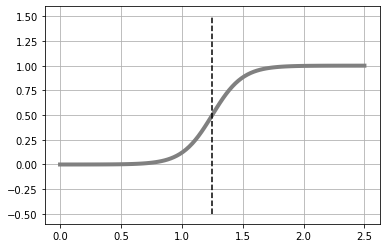

In [7]:
def show_logistic(w):
    xb = np.linspace(X_min, X_max, 100)
    y = logistic(xb, w)
    plt.plot(xb, y, color = 'gray', linewidth = 4)
    i = np.min(np.where( y > 0.5)) # (A)
    B = (xb[i -1] + xb[i]) / 2 # (B)
    plt.plot([B, B], [-.5, 1.5], color = 'k', linestyle='--')
    plt.grid(True)
    return B

W = [8, -10]
show_logistic(W)

(A)와 (B)에서 결정 경계를 구하고 있다. 결정 경계는 y = 0.5가 되는 x의 값이다. (A)의 np.where(y > 0.5)은 y > 0.5를 만족하는 요소 번호를 모두 반환하는 명령문이다.
i = np.min(np.where( y > 0.5 ))의 명령으로 y > 0.5을 만족하는 요소 번호 중에서 가장 작은 인덱스가 i에 들어간다. 즉 i는 y가 0.5를 넘은 직후의 요소 번호이다.

그리고 (B)의 B = (xb[i -1] + xb[i]) / 2로, yㅏ 0.5를 넘은 직후의 xb[i]와,
그 직전의 xb[i - 1]의 평균이 결정 경계의 근사치로서 B에 저장된다.

## **6.1.5 교차 엔트로피 오차**

로지스틱 회귀 모델을 통해 x가 t = 1이 될 확률을 식 6-11로 나타낸다.
$$y = \sigma(w_0x + w_1) = P(t = 1|x)$$

매개 변수 $w_0$와 $w_1$이 곤충의 데이터에 맞도록 최대가능도법을 활용한다.

데이터가 생성될 가능성이 확률적으로 가장 높은 매개 변수를 구한다는 방침이다. 앞 절에서는 특정 데이터 4개
(T = 0, 0, 0, 1 이었다.)에 대해 최대가능도법을 시도했지만 여기에서는 어떤 데이터에도 대응할 수 있도록 생각한다.

먼저 곤충 데이터가 이 모델에서 생성된 확률, 가능도를 구한다. 데이터가 하나뿐이라고 가정하고 무게 x에 대해 t = 1이라면, t = 1이 모델에서 생성될 확률은 로지스틱 회귀 모델의 출력치 y값 그 자체이다. 반대로 t = 0이면 1-y가 된다.

이 생성 확률이 t값에 의해 y나 1 - y로 변해버리는 것은 일반적인 데이터에 대해 생각하면 불편하다. 그래서 수학적인 트릭을 사용하여 클래스의 생성 확률을 다음과 같이 나타낸다.
$$P(t|x) = y^t(1-y)^{1-t}$$

급작스럽게 복잡해진 느낌이지만, t = 1일 때, 다음과 같다.
$$P(t=1|x) = y^1(1-y)^{1-1}= y$$

또한 t = 0일 때는 다음과 같다.
$$P(t=0|x) = y^0(1-y)^{1-0}= 1-y$$




그럼, 데이터이가 N개라면 주어진 $X = x_0, ... , x_{N-1}$에 대한 클래스 $T= t_0,...t_{N-1}$의 생성확률은 어떻게 되는가? 하나하나의 데이터 생성 확률을 모든 데이터에 곱하면 되므로 다음 식과 같다.
이것이 가능도이다.
$$P(T|X) =	\prod_{n=0}^{N-1}y_n^{t_n}(1 - y_n)^{1-t_n} $$
위 식의 대수를 취하고 로그 가능도를 얻는다. 매개 변수 $w_0, w_1$은 이 로그 가능도가 최대가 되도록 구하면 된다.

$$ log P(T|X) = \sum_{n=0}^{N-1}\{t_nlogy_n + (1 - t_n)log(1-y_n)\} $$

5장까지는 평균 제곱 오차가 최소가 되도록 매개 변수를 구하고 있었으므로, 이 식에서도 -1을 곱해준다. 이를 교차 엔트로피 오차라고 한다.

그리고 교차 엔트로피를 N으로 나눈 것을 평균 교차 엔트로피 오차라고 하며 $E(w)$로 정의한다.

$$ E(w) = -log P(T|X) = -\frac1N\sum_{n=0}^{N-1}\{t_nlogy_n + (1 - t_n)log(1-y_n)\}$$

이제 평균 교차 엔트로피 오차를 계산하는 함수 cee_logistic(w, x, t)를 만든다.

In [8]:
def cee_logistic(w, x, t):
    y = logistic(x, w)
    cee = 0
    for n in range(len(y)):
        cee = cee - (t[n] * np.log(y[n]) + (1-t[n])*np.log(1-y[n]))
    cee = cee /X_n
    return cee

W = [1, 1]
cee_logistic(W, X, T)

1.0288191541851066

평균 교차 엔트로피 오차가 어떤 모양인지, 형태를 확인해보자.

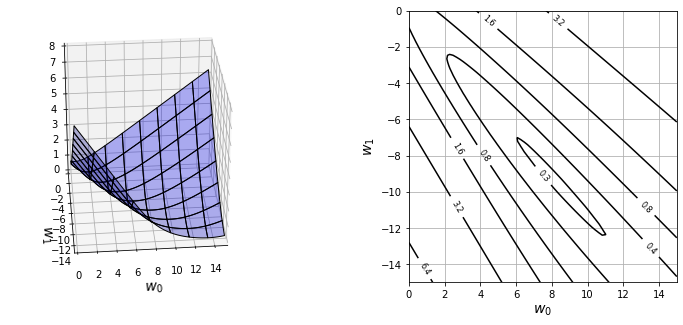

In [9]:
from mpl_toolkits.mplot3d import Axes3D

xn = 80
w_range = np.array([[0, 15], [-15, 0]])
x0 = np.linspace(w_range[0, 0], w_range[0, 1], xn)
x1 = np.linspace(w_range[1, 0], w_range[1, 1], xn)
xx0, xx1 = np.meshgrid(x0, x1)
C = np.zeros((len(x1), len(x0)))
w = np.zeros(2)
for i0 in range(xn):
    for i1 in range(xn):
        w[0] = x0[i0]
        w[1] = x1[i1]
        C[i1, i0] = cee_logistic(w, X, T)



# 표시

plt.figure(figsize = (12, 5))
plt.subplots_adjust(wspace=0.5)
ax = plt.subplot(1, 2, 1, projection='3d')
ax.plot_surface(xx0, xx1, C, color='blue', edgecolor='black', rstride=10, cstride=10, alpha=0.3)
ax.set_xlabel('$w_0$', fontsize=14)
ax.set_ylabel('$w_1$', fontsize = 14)
ax.set_xlim(0, 15)
ax.set_ylim(-15, 0)
ax.set_zlim(0, 8)
ax.view_init(30, -95)

plt.subplot(1, 2, 2)
cont = plt.contour(xx0, xx1, C, 20, colors='black', levels=[0.26, 0.4, 0.8, 1.6, 3.2, 6.4])
cont.clabel(fmt = '%1.1f', fontsize = 8)
plt.xlabel('$w_0$', fontsize = 14)
plt.ylabel('$w_1$', fontsize = 14)
plt.grid(True)
plt.show()

평균 교차 엔트로피 오차 함수는 보자기의 대각선 모서리를 잡고 들어올리는 모양을 하고 있다.
<br>
최소치는 $w_0 = 9, w_1 = -9$의 근처에 있을 것이다.
<hr>


## **6.1.6 학습 규칙의 도출**

교차 엔트로피 오차를 최소화하는 매개 변수의 분석해는 구할 수 없었다. $y_n$ 이 비선형의 시그모이드 함수를 포함하고 있기 때문이다. 그래서 지금까지와 같은 경사 하강법을 사용하여 수치적으로 구하는 것을 고려한다. 경사 하강법을 사용하기 위해 매개 변수를 편미분해야 했다.

그렇다면 식 6-17의 평균 교차 엔트로피 오차 $E(w)$를 $w_0$로 편미분한 것을 찾아보자. 우선, 다음과 같이 나타낸다.
$$E(w) = \frac1N\sum_{n=0}^{N-1}E_n(w)$$

위 식의 합은 다음과 같이 정의했다. 


In [10]:
def dcee_logistic(w, x, t):
    y = logistic(x, w)
    dcee = np.zeros(2)
    for n in range(len(y)):
        dcee[0] = dcee[0] + (y[n] - t[n]) * x[n]
        dcee[1] = dcee[1] + (y[n] - t[n])
    dcee = dcee / X_n

    return dcee

# test
W = [1, 1]
dcee_logistic(W, X, T)

array([0.30857905, 0.39485474])

## **6.1.7 경사 하강법에 의한 해**


w0 = 8.18, w1 = -9.38
CEE = 0.25
Boundary = 1.15 g


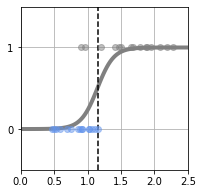

In [11]:
from scipy.optimize import minimize

def fit_logistic(w_init, x, t):
    res1= minimize(cee_logistic, w_init, args=(x, t), jac=dcee_logistic, method="CG") # (A)
    return res1.x

# main
plt.figure(1, figsize=(3,3))
W_init = [1, -1]
W = fit_logistic(W_init, X, T)
print("w0 = {0:.2f}, w1 = {1:.2f}".format(W[0], W[1]))
B = show_logistic(W)
show_data1(X, T)
plt.ylim(-.5, 1.5)
plt.xlim(X_min, X_max)
cee = cee_logistic(W, X, T)
print("CEE = {0:.2f}".format(cee))
print("Boundary = {0:.2f} g".format(B))
plt.show()



## **6.2** 2차원 입력 2클래스 분류

In [12]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(seed=1)
N = 100 # 데이터의 수
K = 3 # 분포 수
T3 = np.zeros((N, 3), dtype = np.uint8)
T2 = np.zeros((N, 2), dtype = np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3] # X0 범위 표시용
X_range1 = [-3, 3] # X1 범위 표시용
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]]) # 분포의 중심
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]])  #
Pi = np.array([0.4, 0.8, 1]) # (A) 각 분포에 대한 비율들
for n in range(N):
    wk = np.random.rand()
    for k in range(K): # (B)
        if wk < Pi[k]:
            T3[n, k] = 1
            break
    for k in range(2):
        X[n, k] = (np.random.randn() * Sig[T3[n, :] == 1, k] +Mu[T3[n, :] == 1,k])
T2[:, 0] = T3[:, 0]
T2[:, 1] = T3[:, 1] | T3[:, 2]

In [14]:
print(X[:5, :])

[[-0.14173827  0.86533666]
 [-0.86972023 -1.25107804]
 [-2.15442802  0.29474174]
 [ 0.75523128  0.92518889]
 [-1.10193462  0.74082534]]


In [15]:
print(T2[:5, :])

[[0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]]


In [16]:
print(T3[:5, :])

[[0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]]


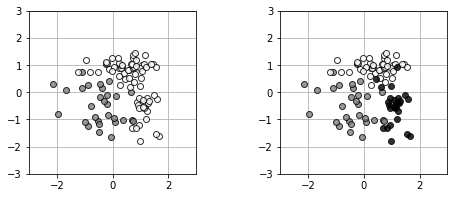

In [19]:
# 데이터 표시
def show_data2(x, t):
    wk, K = t.shape
    c = [[.5, .5, .5], [1, 1, 1], [0, 0, 0]]
    for k in range(K):
        plt.plot(x[t[:, k] == 1, 0], x[t[:, k] == 1, 1], linestyle='none', markeredgecolor='black', marker='o', color=c[k], alpha = 0.8)
        plt.grid(True)

# main
plt.figure(figsize=(7.5, 3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1,2,1)
show_data2(X, T2)
plt.xlim(X_range0)
plt.ylim(X_range1)

plt.subplot(1, 2, 2)
show_data2(X, T3)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()

## **6.2.2** 로지스틱 회귀 모델



In [ ]:
def logistic2(x0, x1, w):
    y = 1/(1+np.exp(-(w[0]* x[0] + w[1] * x[1] + w[2])))